# Ensemble Classifiers for Footprinting
## On all TFs at once

In [341]:
libs <- c(
    'RColorBrewer',
    'ggplot2',
    'xgboost',
    'glmnet',
    'dplyr',
    'tidyr',
    'pROC',
    'ROCR',
    'stringr',
    'caret',
    'caTools'
)

for (lib in libs) {
        if (!require(lib, character.only = TRUE, quietly = TRUE)) {
            install.packages(lib, repos='http://cran.us.r-project.org')
        }
}

(.packages())

[1] "ROCR"         "gplots"       "doMC"         "parallel"     "iterators"   
 [6] "caTools"      "caret"        "lattice"      "stringr"      "pROC"        
[11] "tidyr"        "dplyr"        "glmnet"       "foreach"      "Matrix"      
[16] "xgboost"      "ggplot2"      "RColorBrewer" "stats"        "graphics"    
[21] "grDevices"    "utils"        "datasets"     "methods"      "base"

## source commonly used functions

In [2]:
source("utility_functions.R")
source("stat_functions.R")
source("plot_functions.R")

## Load data

In [20]:
load("train_test_valid_data_sets.Rdata")

## Make ML input and output matrices

In [326]:
# convenience names
train.df <- second.half.train.df
test.df <- first.half.train.df

# drop columns from df for making X that are either useless or cheating
cols.to.drop <- c("start", "end", "csscore", "csTF", "motif", "loc", 
                  "totalsamplecount", "length.h", "length.w", "length.p", "motifpval")

X.train <- as.matrix(train.df[,!(colnames(train.df) %in% cols.to.drop)])
# rownames(X.train) <- NULL

X.test <- as.matrix(test.df[,!(colnames(test.df) %in% cols.to.drop)])
# rownames(X.test) <- NULL

# binarize CS score for y
y.train <- as.numeric(train.df$csscore != 0)
y.test <- as.numeric(test.df$csscore != 0)

In [327]:
colnames(X.train)

[1] "samplecount.w"                       
 [2] "score.w"                             
 [3] "samplecount.h"                       
 [4] "score.h"                             
 [5] "samplecount.p"                       
 [6] "score1.p"                            
 [7] "score2.p"                            
 [8] "score3.p"                            
 [9] "score4.p"                            
[10] "motifscore"                          
[11] "ARIDdomainfactors"                   
[12] "Basichelix-loop-helixfactors(bHLH)"  
[13] "Basichelix-span-helixfactors(bHSH)"  
[14] "Basicleucinezipperfactors(bZIP)"     
[15] "C2CHTHAP-typezincfingerfactors"      
[16] "C2H2zincfingerfactors"               
[17] "CRCdomain"                           
[18] "DM-typeintertwinedzincfingerfactors" 
[19] "Forkhead/wingedhelixfactors"         
[20] "GCMdomainfactors"                    
[21] "Grainyheaddomainfactors"             
[22] "Heatshockfactors"                    
[23] "HeteromericCCAAT-bindingfactors"     
[24] "High-mobilitygroup(HMG)domainfactors"
[25] "Homeodomainfactors"                  
[26] "MADSboxfactors"                      
[27] "NuclearreceptorswithC4zincfingers"   
[28] "OtherC4zincfinger-typefactors"       
[29] "p53domainfactors"                    
[30] "Pairedboxfactors"                    
[31] "Psq-typeHTHdomain"                   
[32] "Relhomologyregion(RHR)factors"       
[33] "Runtdomainfactors"                   
[34] "SANDdomainfactors"                   
[35] "SMAD/NF-1DNA-bindingdomainfactors"   
[36] "STATdomainfactors"                   
[37] "T-Boxfactors"                        
[38] "TATA-bindingproteins"                
[39] "TEAdomainfactors"                    
[40] "Tryptophanclusterfactors"            
[41] "gc.content"                          
[42] "log.TSS.dist"

## Train decision tree model

In [300]:
param <- list("objective" = "binary:logistic",
          "max.depth" = 8,
          "eta" = 0.005,
          "eval.metric" = "auc"
          )

gbdt.medium <- xgboost(
    params = param,
    data = X.train,
    label = y.train,
    nround = 250,
    verbose = FALSE,
    missing = NA
)

gbdt.medium$Model.Name <- "trees with classes"

In [302]:
medium.pred.df <- make.pred.df.from.model(gbdt.medium, X.test, y.test)
medium.stat.df <- make.stats.df.from.preds(medium.pred.df, num.roc.points = 1001)

In [14]:
# importance.matrix.smalltest <- xgb.importance(colnames(X.test),model=gbdt.smalltest)

In [301]:
# xgb.plot.importance(importance.matrix.smalltest) + theme_minimal()

## don't use piq scores

In [303]:
# drop columns from df for making X that are either useless or cheating
cols.to.drop <- c("start", "end", "csscore", "csTF", "motif", "loc", 
                  "totalsamplecount", "length.h", "length.w", "length.p", "motifpval",
                 'samplecount.p', 'score1.p', 'score2.p', 'score3.p', 'score4.p')

X.train <- as.matrix(train.df[,!(colnames(train.df) %in% cols.to.drop)])
# rownames(X.train) <- NULL

X.test <- as.matrix(test.df[,!(colnames(test.df) %in% cols.to.drop)])
# rownames(X.test) <- NULL

# binarize CS score for y
y.train <- as.numeric(train.df$csscore != 0)
y.test <- as.numeric(test.df$csscore != 0)

In [304]:
param <- list("objective" = "binary:logistic",
          "max.depth" = 8,
          "eta" = 0.005,
          "eval.metric" = "auc"
          )

gbdt.smalltest.nopiq <- xgboost(
    params = param,
    data = X.train,
    label = y.train,
    nround = 250,
    verbose = FALSE,
    missing = NA
)

gbdt.smalltest.nopiq$Model.Name <- "trees no piq with classes"

In [305]:
smalltest.nopiq.pred.df <- make.pred.df.from.model(gbdt.smalltest.nopiq, X.test, y.test)
smalltest.nopiq.stat.df <- make.stats.df.from.preds(smalltest.nopiq.pred.df, num.roc.points = 1001)

In [75]:
importance.matrix.smalltest.nopiq <- xgb.importance(colnames(X.test),model=gbdt.smalltest.nopiq)

In [144]:
df <- as_data_frame(importance.matrix.smalltest.nopiq)
df.tf <- subset(df, Feature %in% tf.class.names)
df.notf <- subset(df, !(Feature %in% tf.class.names))
tfclass.row <- c("TF.class", unname(as.list(colSums(df.tf[!(colnames(df.tf) %in% c("Feature"))]))) )
names(tfclass.row) <- colnames(df)
df.sum <- rbind(df.notf,tfclass.row)

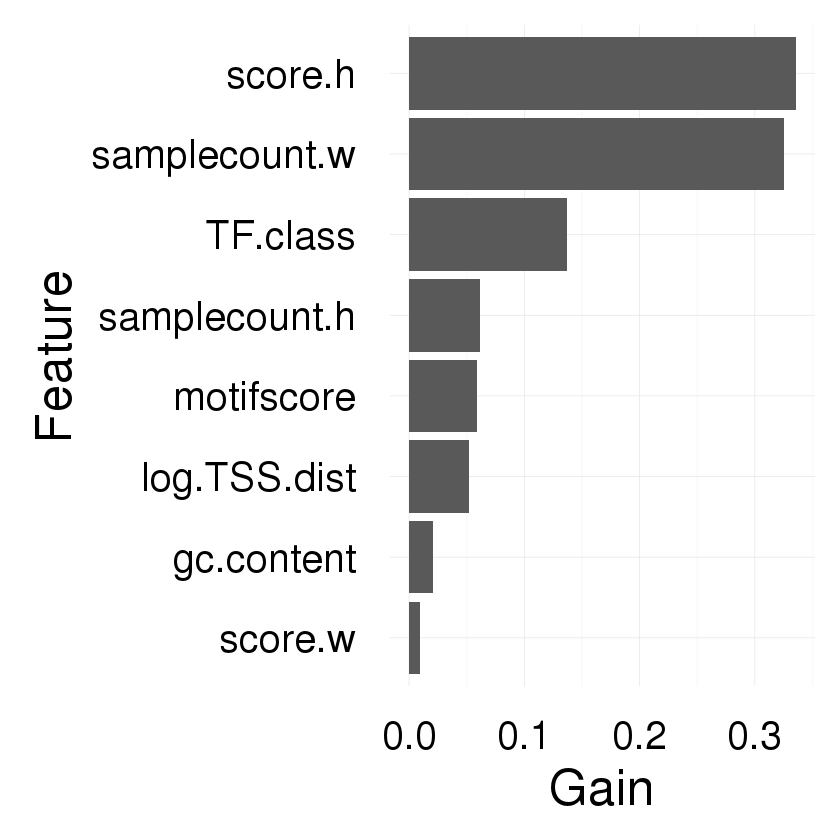

In [206]:
ggplot(data=df.sum, aes(x=reorder(Feature, Gain), y=Gain)) +
    geom_bar(stat="identity") +
    coord_flip() +
    theme_minimal(base_size = 30) +
    labs(x = "Feature", y="Gain")
    #theme(text = element_text(size=20)

In [148]:
# xgb.plot.importance(importance.matrix.smalltest.nopiq) + theme_minimal()

## Train without TF Classes

In [306]:
# drop columns from df for making X that are either useless or cheating
cols.to.drop <- c("start", "end", "csscore", "csTF", "motif", "loc", 
                  "totalsamplecount", "length.h", "length.w", "length.p", "motifpval")
cols.to.drop <- c(cols.to.drop, tf.class.names)

X.train <- as.matrix(train.df[,!(colnames(train.df) %in% cols.to.drop)])
# rownames(X.train) <- NULL

X.test <- as.matrix(test.df[,!(colnames(test.df) %in% cols.to.drop)])
# rownames(X.test) <- NULL

# binarize CS score for y
y.train <- as.numeric(train.df$csscore != 0)
y.test <- as.numeric(test.df$csscore != 0)

In [307]:
gbdt.small.no.tf.classes <- xgboost(
    params = param,
    data = X.train,
    label = y.train,
    nround = 250,
    verbose = FALSE,
    missing = NA
)

gbdt.small.no.tf.classes$Model.Name <- "trees no classes"

In [308]:
small.no.tf.classes.pred.df <- make.pred.df.from.model(gbdt.small.no.tf.classes, X.test, y.test)
small.no.tf.classes.stat.df <- make.stats.df.from.preds(small.no.tf.classes.pred.df, num.roc.points = 1001)

## Train a linear model on all features

In [309]:
all.regressors <- paste(colnames(X.train), collapse=" + ")
glm.formula <- paste("CHIPseq.bound ~ ", all.regressors, sep='')

glm.df.train <- as.data.frame(cbind("CHIPseq.bound"=y.train, X.train))
glm.df.test <- as.data.frame(cbind("CHIPseq.bound"=y.test, X.test))

glm.all <- glm(as.formula(glm.formula), data=glm.df.train, family=binomial)
glm.all$Model.Name <- "glm small"

In [310]:
glm.pred.df <- make.pred.df.from.glm(glm.all, glm.df.test)
glm.stat.df <- make.stats.df.from.preds(glm.pred.df, num.roc.points = 1001)

## Linear models on each feature individually

In [311]:
stats.regressors.df <- data.frame()

for (this.regressor in colnames(X.train)) {
    
    glm.formula <- paste("CHIPseq.bound ~ ", this.regressor, sep='')

    glm.df.train <- as.data.frame(cbind("CHIPseq.bound"=y.train, X.train))
    glm.df.test <- as.data.frame(cbind("CHIPseq.bound"=y.test, X.test))

    glm.single <- glm(as.formula(glm.formula), data=glm.df.train, family=binomial)
    glm.single$Model.Name <- paste("glm ", this.regressor, sep='')
    
    glm.pred.single.df <- make.pred.df.from.glm(glm.single, glm.df.test)
    glm.stat.single.df <- make.stats.df.from.preds(glm.pred.single.df, num.roc.points = 1001)
    
    stats.regressors.df <- rbind(stats.regressors.df, glm.stat.single.df)
    
}

## Plot results from all models

In [318]:
stats.hwm.regressors.df <- subset(stats.regressors.df, Model.Name %in% c('glm score.h', 'glm samplecount.w', 'glm motifscore'))

In [319]:
all.stats.df <- rbind(
#     stats.regressors.df,
    stats.hwm.regressors.df,
#     smalltest.stat.df,
#     small.no.tf.classes.stat.df,
    glm.stat.df,
    smalltest.nopiq.stat.df
#     big.stat.df,
#     smaller.nopiq.stat.df
)

In [320]:
all.stats.df[all.stats.df$Model.Name == 'glm samplecount.w', 'Model.Name'] <- 'Wellington Sample Count'
all.stats.df[all.stats.df$Model.Name == 'glm score.h', 'Model.Name'] <- 'Hint Score'
all.stats.df[all.stats.df$Model.Name == 'glm motifscore', 'Model.Name'] <- 'Motif Score'
all.stats.df[all.stats.df$Model.Name == 'glm small', 'Model.Name'] <- 'Linear Model'
all.stats.df[all.stats.df$Model.Name == 'trees no piq with classes', 'Model.Name'] <- 'Decision Trees'

In [321]:
max(smalltest.stat.df$MattCC)

[1] 0.5762009

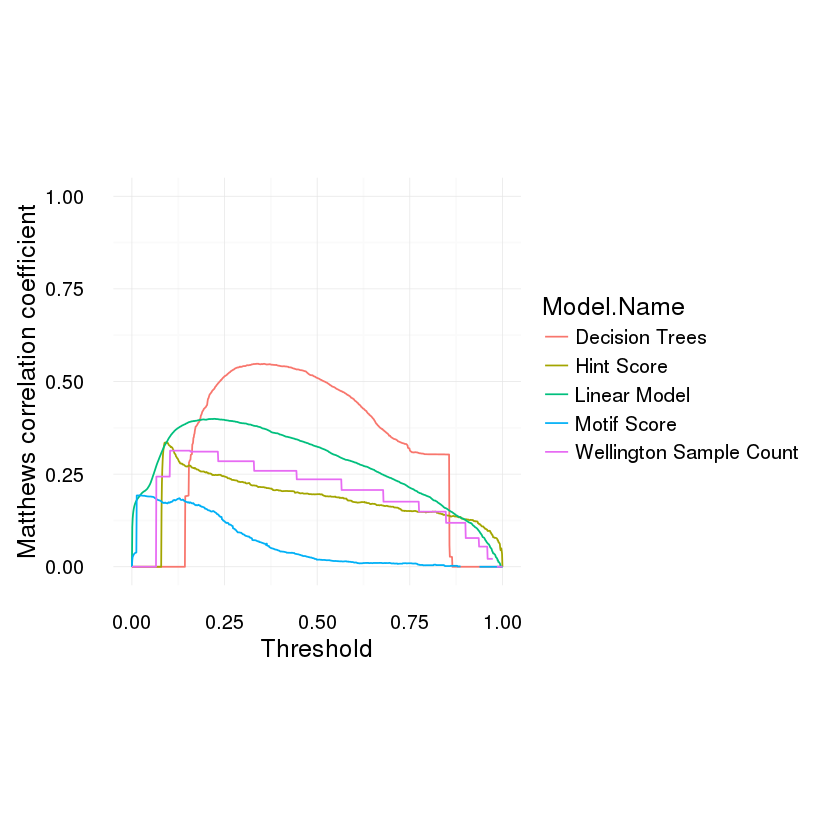

In [374]:
plot.mattcc.curve(all.stats.df) + theme_minimal(base_size = 15)

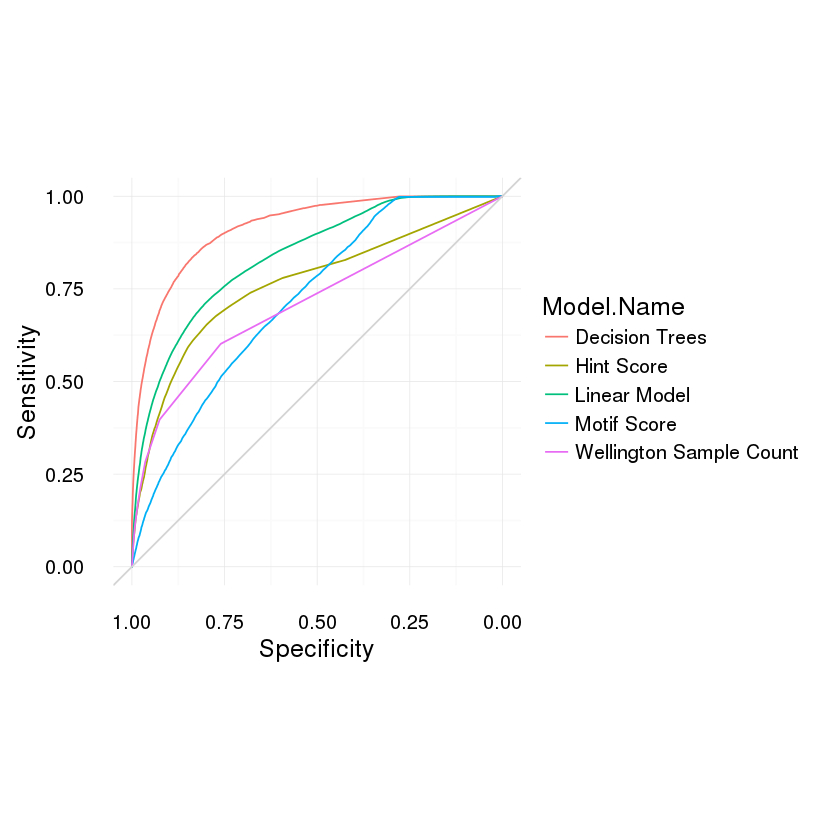

In [323]:
plot.roc.curve(all.stats.df) + theme_minimal(base_size = 15)

Warning message:
“Removed 143 rows containing missing values (geom_path).”

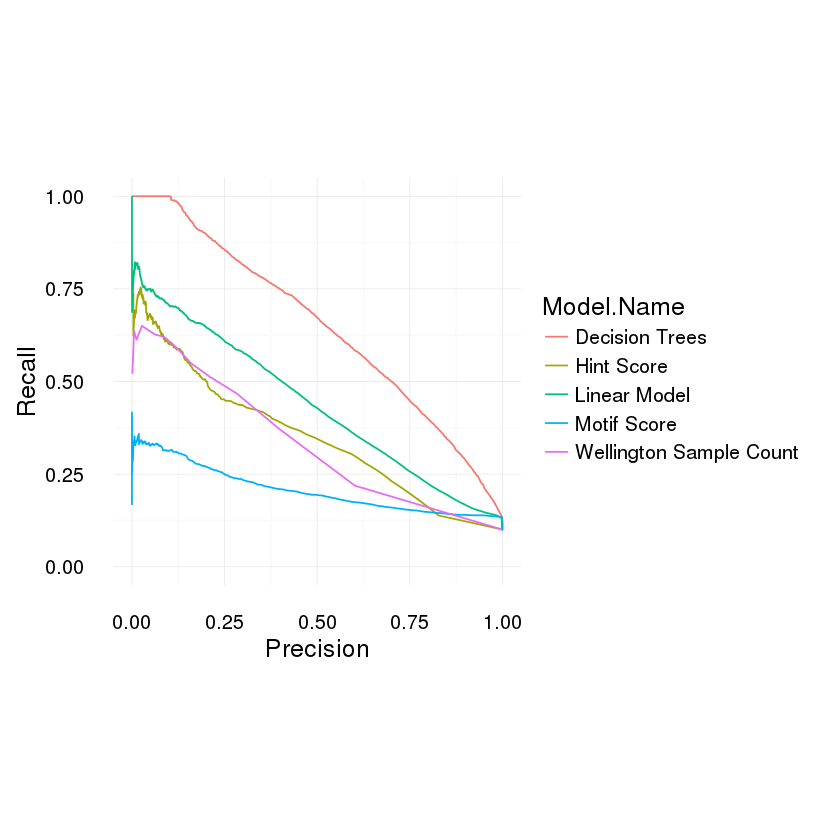

In [324]:
plot.precrecall.curve(all.stats.df) + theme_minimal(base_size = 15)

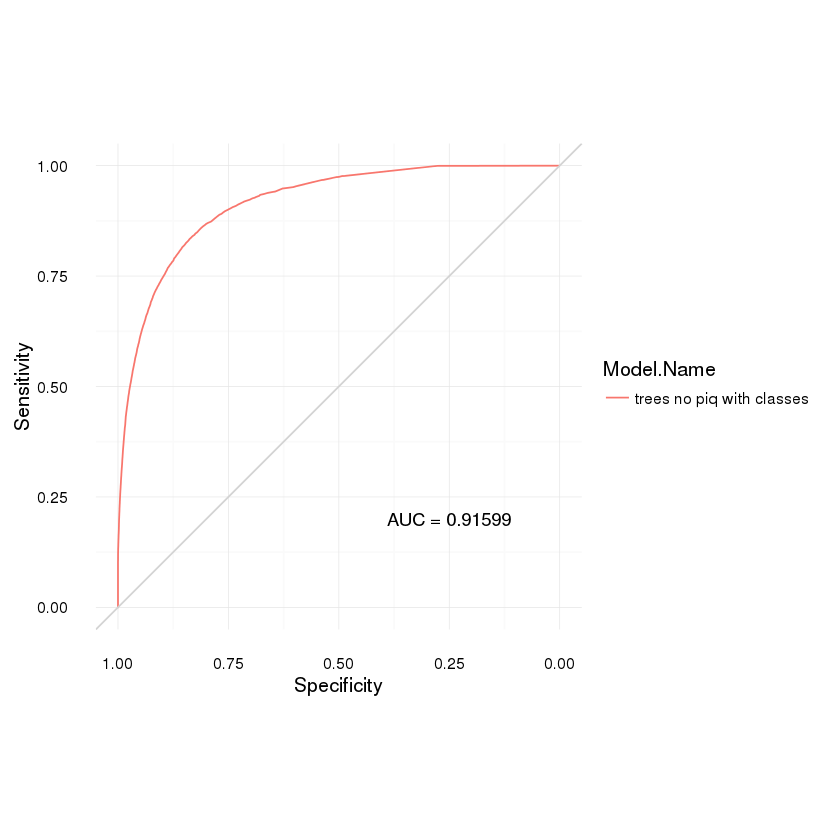

In [325]:
plot.roc.curve(smalltest.nopiq.stat.df, printAUC = TRUE)

Warning message:
“Removed 275 rows containing missing values (geom_path).”

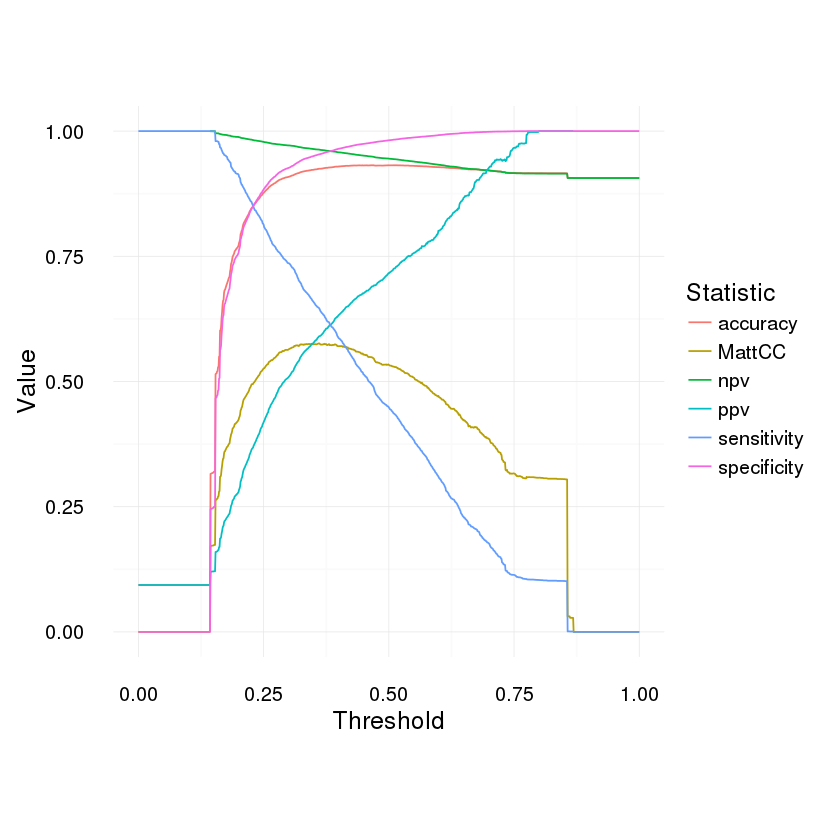

In [375]:
plot.all.curve(smalltest.stat.df) + theme_minimal(base_size = 15)

In [39]:
anova(glm.all, test="Chisq")

,Df,Deviance,Resid. Df,Resid. Dev,Pr(>Chi)
NULL,NA,NA,385311,246448.4,NA
samplecount.w,1,27145.81780,385310,219302.6,0.000000e+00
score.w,1,1237.97242,385309,218064.6,3.411455e-271
samplecount.h,1,12392.08284,385308,205672.5,0.000000e+00
score.h,1,293.77153,385307,205378.7,7.495345e-66
samplecount.p,1,717.81643,385306,204660.9,3.994595e-158
score1.p,1,171.20224,385305,204489.7,4.041937e-39
score2.p,1,5668.60510,385304,198821.1,0.000000e+00
score3.p,1,17.01132,385303,198804.1,3.715758e-05
score4.p,1,901.54551,385302,197902.6,4.527374e-198


In [329]:
max.eig <- function(N, sigma) {
    d <- matrix(rnorm(N**2, sd = sigma), nrow = N)
    E <- eigen(d)$values
    abs(E)[[1]]
}

In [330]:
foreach(n = 1:5, m = 1:5) %do% max.eig(n, m)

[[1]]
[1] 0.2164162

[[2]]
[1] 5.079306

[[3]]
[1] 4.513257

[[4]]
[1] 7.821847

[[5]]
[1] 12.71426

In [333]:
library(doMC)
registerDoMC(cores=12)

In [335]:
foreach(n = 1:12) %dopar% max.eig(n, 1)

[[1]]
[1] 0.3669241

[[2]]
[1] 1.578628

[[3]]
[1] 1.78952

[[4]]
[1] 2.110999

[[5]]
[1] 3.666708

[[6]]
[1] 3.310088

[[7]]
[1] 2.541844

[[8]]
[1] 2.977253

[[9]]
[1] 3.045458

[[10]]
[1] 4.105191

[[11]]
[1] 3.360513

[[12]]
[1] 3.747324

In [337]:
medium.pred.df <- make.pred.df.from.model(gbdt.medium, X.test, y.test)
# medium.stat.df <- make.stats.df.from.preds(medium.pred.df, num.roc.points = 1001)

In [363]:
str(medium.pred.df)

'data.frame':	410022 obs. of  3 variables:
 $ ChIPseq.bound: num  0 0 0 0 0 0 0 0 0 0 ...
 $ Prediction   : num  0.143 0.143 0.143 0.23 0.154 ...
 $ Model.Name   : chr  "trees with classes" "trees with classes" "trees with classes" "trees with classes" ...


In [361]:
testres <- data.frame(res=rnorm(15000), cat=rbinom(15000,1, .2))
 require(ROCR)
 pred <- prediction(testres$res, testres$cat)
 perf <- performance(pred,"sens")
str(perf)
 perf <- performance(pred,"mat")
str(perf)

Formal class 'performance' [package "ROCR"] with 6 slots
  ..@ x.name      : chr "Cutoff"
  ..@ y.name      : chr "Sensitivity"
  ..@ alpha.name  : chr "none"
  ..@ x.values    :List of 1
  .. ..$ : num [1:15001] Inf 4.05 3.65 3.59 3.46 ...
  ..@ y.values    :List of 1
  .. ..$ : num [1:15001] 0 0.00033 0.00033 0.00033 0.00033 ...
  ..@ alpha.values: list()
Formal class 'performance' [package "ROCR"] with 6 slots
  ..@ x.name      : chr "Cutoff"
  ..@ y.name      : chr "Matthews correlation coefficient"
  ..@ alpha.name  : chr "none"
  ..@ x.values    :List of 1
  .. ..$ : num [1:15001] Inf 4.05 3.65 3.59 3.46 ...
  ..@ y.values    :List of 1
  .. ..$ : num [1:15001] NaN 0.01624 0.00858 0.00464 0.00196 ...
  ..@ alpha.values: list()


In [372]:
pred <- prediction(medium.pred.df$Prediction, medium.pred.df$ChIPseq.bound)
perf <- performance(pred,"sens", "spec")
str(perf)

Formal class 'performance' [package "ROCR"] with 6 slots
  ..@ x.name      : chr "Specificity"
  ..@ y.name      : chr "Sensitivity"
  ..@ alpha.name  : chr "Cutoff"
  ..@ x.values    :List of 1
  .. ..$ : num [1:38261] 1 1 1 1 1 1 1 1 1 1 ...
  ..@ y.values    :List of 1
  .. ..$ : num [1:38261] 0 0.000777 0.000826 0.00085 0.003666 ...
  ..@ alpha.values:List of 1
  .. ..$ : num [1:38261] Inf 0.868 0.866 0.861 0.857 ...


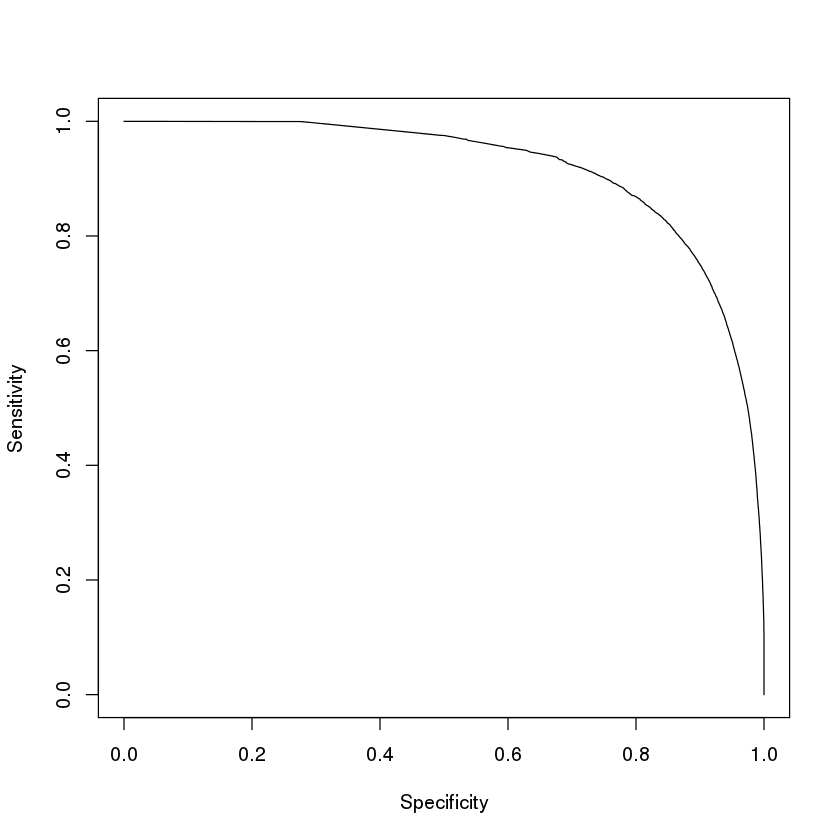

In [373]:
plot(perf)